# Example - Animal Shelter

<h1>Index<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Create-a-target" data-toc-modified-id="Create-a-target-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Create a target</a></span></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Modeling</a></span><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Data</a></span></li></ul></li><li><span><a href="#Checking-the-support-in-the-different-environments" data-toc-modified-id="Checking-the-support-in-the-different-environments-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Checking the support in the different environments</a></span><ul class="toc-item"><li><span><a href="#Benchmark" data-toc-modified-id="Benchmark-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Benchmark</a></span></li></ul></li><li><span><a href="#Challenger-model" data-toc-modified-id="Challenger-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Challenger model</a></span></li><li><span><a href="#TRF-as-feature-selection" data-toc-modified-id="TRF-as-feature-selection-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>TRF as feature selection</a></span></li><li><span><a href="#Domain-classifier" data-toc-modified-id="Domain-classifier-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Domain classifier</a></span></li></ul></div>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from time_robust_forest.models import TimeForestClassifier
from time_robust_forest.functions import check_categoricals_match, check_numerical_match

np.random.seed(42)

In [3]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    plt.rcParams['figure.figsize'] = (12, 4)

In [4]:
set_style()

In [5]:
DATASETS_PATH = "~/Documents/datasets/animal_shelter/"

In [6]:
intakes = pd.read_csv(DATASETS_PATH + "Austin_Animal_Center_Intakes.csv")
outcomes = pd.read_csv(DATASETS_PATH + "Austin_Animal_Center_Outcomes.csv")

In [7]:
intakes.shape

(124120, 12)

In [8]:
intakes.nunique()

Animal ID           110926
Name                 19748
DateTime             87660
MonthYear            87660
Found Location       53703
Intake Type              6
Intake Condition        10
Animal Type              5
Sex upon Intake          5
Age upon Intake         52
Breed                 2629
Color                  595
dtype: int64

In [9]:
intakes.dtypes

Animal ID           object
Name                object
DateTime            object
MonthYear           object
Found Location      object
Intake Type         object
Intake Condition    object
Animal Type         object
Sex upon Intake     object
Age upon Intake     object
Breed               object
Color               object
dtype: object

In [10]:
intakes.head()

,Animal ID,Name,DateTime,MonthYear,Found Location,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,Color
0,A786884,*Brock,01/03/2019 04:19:00 PM,01/03/2019 04:19:00 PM,2501 Magin Meadow Dr in Austin (TX),Stray,Normal,Dog,Neutered Male,2 years,Beagle Mix,Tricolor
1,A706918,Belle,07/05/2015 12:59:00 PM,07/05/2015 12:59:00 PM,9409 Bluegrass Dr in Austin (TX),Stray,Normal,Dog,Spayed Female,8 years,English Springer Spaniel,White/Liver
2,A724273,Runster,04/14/2016 06:43:00 PM,04/14/2016 06:43:00 PM,2818 Palomino Trail in Austin (TX),Stray,Normal,Dog,Intact Male,11 months,Basenji Mix,Sable/White
3,A665644,NaN,10/21/2013 07:59:00 AM,10/21/2013 07:59:00 AM,Austin (TX),Stray,Sick,Cat,Intact Female,4 weeks,Domestic Shorthair Mix,Calico
4,A682524,Rio,06/29/2014 10:38:00 AM,06/29/2014 10:38:00 AM,800 Grove Blvd in Austin (TX),Stray,Normal,Dog,Neutered Male,4 years,Doberman Pinsch/Australian Cattle Dog,Tan/Gray


In [11]:
intakes["Age upon Intake"] = intakes["Age upon Intake"].apply(lambda x: float(x.split(" ")[0]) / 12.0 if "month" in x else float(x.split(" ")[0]))

In [12]:
outcomes

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A794011,Chunk,05/08/2019 06:20:00 PM,05/08/2019 06:20:00 PM,05/02/2017,Rto-Adopt,NaN,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White
1,A776359,Gizmo,07/18/2018 04:02:00 PM,07/18/2018 04:02:00 PM,07/12/2017,Adoption,NaN,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown
2,A821648,NaN,08/16/2020 11:38:00 AM,08/16/2020 11:38:00 AM,08/16/2019,Euthanasia,NaN,Other,Unknown,1 year,Raccoon,Gray
3,A720371,Moose,02/13/2016 05:59:00 PM,02/13/2016 05:59:00 PM,10/08/2015,Adoption,NaN,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff
4,A674754,NaN,03/18/2014 11:47:00 AM,03/18/2014 11:47:00 AM,03/12/2014,Transfer,Partner,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby
...,...,...,...,...,...,...,...,...,...,...,...,...
124486,A828810,*Rory,03/03/2021 04:20:00 PM,03/03/2021 04:20:00 PM,03/26/2020,Adoption,NaN,Dog,Spayed Female,11 months,Chihuahua Shorthair/American Staffordshire Ter...,Brown/Tan
124487,A791377,Bolt,12/28/2020 03:49:00 PM,12/28/2020 03:49:00 PM,01/14/2019,Return to Owner,NaN,Dog,Neutered Male,1 year,Siberian Husky Mix,White
124488,A829611,Chief,03/03/2021 04:59:00 PM,03/03/2021 04:59:00 PM,02/17/2012,Rto-Adopt,NaN,Cat,Neutered Male,9 years,Domestic Shorthair,Orange Tabby
124489,A829964,NaN,03/03/2021 05:57:00 PM,03/03/2021 05:57:00 PM,11/27/2020,Adoption,NaN,Dog,Neutered Male,3 months,Labrador Retriever,Cream


In [13]:
outcomes.rename(columns={"DateTime": "Outcome DateTime", "Outcome Type": "Outcome"},
                inplace=True)

## Create a target

Let's create if the animal was adopted in the following 6 months.

In [14]:
data = intakes.merge(outcomes[["Animal ID", "Outcome DateTime", "Outcome"]], on="Animal ID")

In [15]:
data.head()

,Animal ID,Name,DateTime,MonthYear,Found Location,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,Color,Outcome DateTime,Outcome
0,A786884,*Brock,01/03/2019 04:19:00 PM,01/03/2019 04:19:00 PM,2501 Magin Meadow Dr in Austin (TX),Stray,Normal,Dog,Neutered Male,2.000000,Beagle Mix,Tricolor,01/08/2019 03:11:00 PM,Transfer
1,A706918,Belle,07/05/2015 12:59:00 PM,07/05/2015 12:59:00 PM,9409 Bluegrass Dr in Austin (TX),Stray,Normal,Dog,Spayed Female,8.000000,English Springer Spaniel,White/Liver,07/05/2015 03:13:00 PM,Return to Owner
2,A724273,Runster,04/14/2016 06:43:00 PM,04/14/2016 06:43:00 PM,2818 Palomino Trail in Austin (TX),Stray,Normal,Dog,Intact Male,0.916667,Basenji Mix,Sable/White,04/21/2016 05:17:00 PM,Return to Owner
3,A665644,NaN,10/21/2013 07:59:00 AM,10/21/2013 07:59:00 AM,Austin (TX),Stray,Sick,Cat,Intact Female,4.000000,Domestic Shorthair Mix,Calico,10/21/2013 11:39:00 AM,Transfer
4,A682524,Rio,06/29/2014 10:38:00 AM,06/29/2014 10:38:00 AM,800 Grove Blvd in Austin (TX),Stray,Normal,Dog,Neutered Male,4.000000,Doberman Pinsch/Australian Cattle Dog,Tan/Gray,07/02/2014 02:16:00 PM,Return to Owner


In [16]:
data["time_until_adoption"] = (pd.to_datetime(data["Outcome DateTime"]) - pd.to_datetime(data["DateTime"])).dt.days
data["time_until_adoption"]

0          4
1          0
2          6
3          0
4          3
          ..
160423     0
160424     0
160425     1
160426     6
160427    53
Name: time_until_adoption, Length: 160428, dtype: int64

In [17]:
data["time_until_adoption"].describe()

count    160428.000000
mean         17.239223
std         248.480625
min       -2583.000000
25%           0.000000
50%           5.000000
75%          24.000000
max        2553.000000
Name: time_until_adoption, dtype: float64

In [18]:
data["Outcome"].unique()

array(['Transfer', 'Return to Owner', 'Adoption', 'Euthanasia',
       'Disposal', 'Died', 'Rto-Adopt', 'Missing', nan, 'Relocate'],
      dtype=object)

In [19]:
data["target"] = (data["time_until_adoption"] < 30) & (data["Outcome"] == "Adoption")

In [20]:
data["target"] = data["target"].astype(int)

In [21]:
data["target"].mean()

0.2998167402199117

## Modeling

### Data

In [22]:
TIME_COLUMN = "Year"
TARGET = "target"

In [23]:
columns_to_label_encode = ["Intake Type", 
                           "Intake Condition",
                           "Animal Type",
                           "Sex upon Intake",
                           "Breed",
                           "Color"]

In [24]:
le = LabelEncoder()
for column in columns_to_label_encode:
    print(column)
    data[column].fillna("None", inplace=True)
    data[column] = le.fit_transform(data[[column]])

Intake Type
Intake Condition
Animal Type


/Users/luis.moneda/opt/miniconda3/envs/ml3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Sex upon Intake
Breed
Color


In [25]:
features = ["Age upon Intake"] + columns_to_label_encode

In [26]:
data["DateTime"].min()

'01/01/2014 01:05:00 PM'

In [27]:
data["DateTime"].max()

'12/31/2020 12:50:00 PM'

In [28]:
data["Year"] = pd.to_datetime(data["DateTime"]).apply(lambda x: int(x.year))

In [29]:
data["Year"]

0         2019
1         2015
2         2016
3         2013
4         2014
          ... 
160423    2021
160424    2021
160425    2018
160426    2021
160427    2021
Name: Year, Length: 160428, dtype: int64

In [30]:
data["Year"].min()

2013

In [31]:
data["Year"].max()

2021

In [32]:
training_start_year = 2014
training_end_year = 2017
holdout_end_year = 2020

In [33]:
in_time = data[data["Year"] <= training_end_year]
in_time = in_time[in_time["Year"] >= training_start_year]
out_of_time = data[data["Year"] > training_end_year]

In [34]:
train, test = train_test_split(in_time, 
                               test_size=0.2,
                               random_state=42)

In [35]:
train.shape

(75272, 17)

In [36]:
test.shape

(18818, 17)

In [37]:
out_of_time.shape

(61402, 17)

In [38]:
median_input = train.median()
train.fillna(median_input, inplace=True)
test.fillna(median_input, inplace=True)
out_of_time.fillna(median_input, inplace=True)

/Users/luis.moneda/opt/miniconda3/envs/ml3/lib/python3.6/site-packages/pandas/core/series.py:4523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


## Checking the support in the different environments

In [39]:
check_categoricals_match(train, columns_to_label_encode, "Year")

Year
2014    1.0
2015    1.0
2016    1.0
2017    1.0
Name: Intake Type, dtype: float64
Year
2014    1.0
2015    1.0
2016    1.0
2017    1.0
Name: Intake Condition, dtype: float64
Year
2014    1.0
2015    1.0
2016    1.0
2017    1.0
Name: Animal Type, dtype: float64
Year
2014    1.0
2015    1.0
2016    1.0
2017    1.0
Name: Sex upon Intake, dtype: float64
Year
2014    0.580352
2015    0.560598
2016    0.429792
2017    0.413241
Name: Breed, dtype: float64
Year
2014    0.645435
2015    0.613588
2016    0.611465
2017    0.626327
Name: Color, dtype: float64


0.8533665917389023

In [40]:
check_numerical_match(train, ["Age upon Intake"], "Year", verbose=True, n_q=10)

Year
2014    0.8
2015    0.9
2016    1.0
2017    0.9
Name: Age upon Intake_quant, dtype: float64


/Users/luis.moneda/opt/miniconda3/envs/ml3/lib/python3.6/site-packages/time_robust_forest/functions.py:186: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels=[i for i in range(1, n_q + 1)],


0.9

### Benchmark

In [41]:
from pycaret.classification import *

In [42]:
clf1 = setup(train[features + [TARGET]], 
             target="target",
             session_id=2, 
             log_experiment=False, 
             experiment_name="shelter",
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     fold=5,
                     n_iter=50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6874,0.7817,0.7666,0.4708,0.5834,0.3554,0.3825
1,0.7006,0.7946,0.7866,0.4849,0.6000,0.3816,0.4102
2,0.6859,0.7772,0.7746,0.4696,0.5847,0.3557,0.3846
3,0.6942,0.7871,0.7840,0.4784,0.5942,0.3712,0.4004
4,0.6962,0.7905,0.7767,0.4803,0.5935,0.3719,0.3993
Mean,0.6929,0.7862,0.7777,0.4768,0.5912,0.3671,0.3954
SD,0.0055,0.0062,0.0071,0.0058,0.0063,0.0102,0.0104


In [43]:
tuned_rf

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=11, max_features='sqrt', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0001,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=7, min_weight_fraction_leaf=0.0,
                       n_estimators=250, n_jobs=-1, oob_score=False,
                       random_state=2, verbose=0, warm_start=False)

In [44]:
benchmark_model = tuned_rf
benchmark_model.fit(train[features], train[TARGET])

train["benchmark_prediction_opt"] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction_opt"] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction_opt"] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

In [45]:
print(roc_auc_score(train[TARGET], train["benchmark_prediction_opt"]))
print(roc_auc_score(test[TARGET], test["benchmark_prediction_opt"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["benchmark_prediction_opt"]))

0.7946691360135414
0.7872893826981108
0.7888780899420342


In [46]:
benchmark_model = RandomForestClassifier(n_estimators=250, max_depth=8)
benchmark_model.fit(train[features], train[TARGET])

train["benchmark_prediction"] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction"] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction"] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

In [47]:
print(roc_auc_score(train[TARGET], train["benchmark_prediction"]))
print(roc_auc_score(test[TARGET], test["benchmark_prediction"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["benchmark_prediction"]))

0.7915515579550967
0.7816972073299906
0.7872495208567774


## Challenger model

In [48]:
train.reset_index(drop=True, inplace=True)

In [49]:
train[features + [TIME_COLUMN]]

,Age upon Intake,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Breed,Color,Year
0,6.000000,4,5,2,2,2231,56,2015
1,2.000000,4,5,2,2,1982,252,2017
2,1.000000,4,5,1,0,1160,489,2017
3,0.583333,2,5,2,1,1278,9,2017
4,1.000000,3,5,2,4,1563,455,2016
...,...,...,...,...,...,...,...,...
75267,0.583333,4,5,2,1,2435,530,2017
75268,1.000000,4,6,1,5,1160,155,2014
75269,1.000000,4,5,2,1,822,416,2017
75270,0.500000,4,5,2,1,822,130,2014


In [50]:
train["Year"].value_counts()

2015    19136
2017    19000
2016    18852
2014    18284
Name: Year, dtype: int64

In [51]:
challenger_model = TimeForestClassifier(time_column=TIME_COLUMN,
                                        n_estimators=250,
                                        min_sample_periods=30,
                                        max_depth=11,
                                        multi=True)
challenger_model.fit(train[features + [TIME_COLUMN]], train[TARGET].values)

train["challenger_prediction"] = challenger_model.predict_proba(train[features])[:, 1]
test["challenger_prediction"] = challenger_model.predict_proba(test[features])[:, 1]
out_of_time["challenger_prediction"] = challenger_model.predict_proba(out_of_time[features])[:, 1]

In [52]:
print(roc_auc_score(train[TARGET], train["challenger_prediction"]))
print(roc_auc_score(test[TARGET], test["challenger_prediction"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["challenger_prediction"]))

0.790822996924873
0.7835264898096471
0.7871875006845034


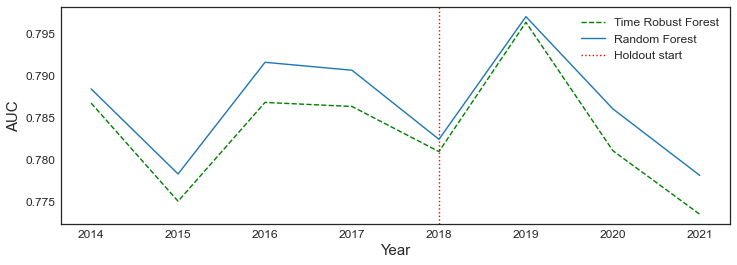

In [53]:
fig, ax = plt.subplots()
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt"])).plot(label="Random Forest", ax=ax)
#plt.title("AUC by year on the GE Club News dataset - Out of time set from {}".format(train_end_date), fontsize=15)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(training_end_year + 1, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=12, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)
plt.savefig("../images/shelter_test_holdout_auc_years.eps", format="eps")
plt.show()

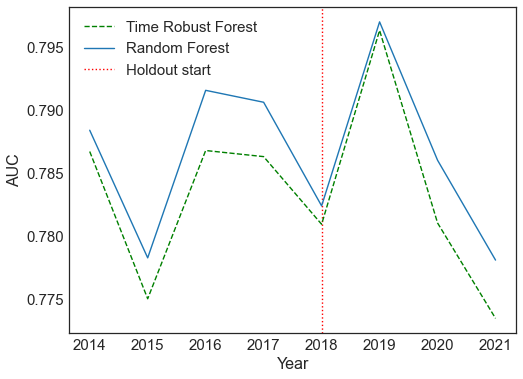

In [54]:
fig, ax = plt.subplots(figsize=(8, 6))
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt"])).plot(label="Random Forest", ax=ax)

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(training_end_year + 1, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=15, bbox_to_anchor=(0.45, 1.0))
plt.ylabel("AUC", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.savefig("../images/shelter_test_holdout_auc_years_square.eps", format="eps")
plt.show()

In [56]:
#pd.concat([test, out_of_time])[[TIME_COLUMN, "benchmark_prediction", "benchmark_prediction_opt", "challenger_prediction"]].to_csv("results/8_animal_shelter_example.csv")

## TRF as feature selection

In [57]:
challenger_model.feature_importance()

Age upon Intake     8496
Color               8490
Breed               8056
Sex upon Intake     6006
Intake Type         2278
Animal Type         1611
Intake Condition    1585
Name: Feature Importance, dtype: int64

In [58]:
selected_features = [feature for feature in features if feature in challenger_model.feature_importance().index]
selected_features

['Age upon Intake',
 'Intake Type',
 'Intake Condition',
 'Animal Type',
 'Sex upon Intake',
 'Breed',
 'Color']

In [59]:
clf1 = setup(train[selected_features + [TARGET]], 
             target="target",
             session_id=22, 
             log_experiment=False, 
             experiment_name="shelter_fs",
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     fold=5,
                     n_iter=50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6999,0.7886,0.7753,0.4831,0.5952,0.3766,0.4033
1,0.6926,0.7885,0.7693,0.4754,0.5877,0.3637,0.3906
2,0.6849,0.7874,0.7757,0.4677,0.5836,0.3542,0.3836
3,0.6805,0.7726,0.7673,0.4631,0.5776,0.3450,0.3736
4,0.6965,0.7861,0.7717,0.4795,0.5915,0.3704,0.3970
Mean,0.6909,0.7847,0.7719,0.4738,0.5871,0.3620,0.3896
SD,0.0072,0.0061,0.0033,0.0074,0.0061,0.0113,0.0104


In [60]:
tuned_rf

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0001, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
                       oob_score=False, random_state=22, verbose=0,
                       warm_start=False)

In [61]:
benchmark_model = tuned_rf
benchmark_model.fit(train[selected_features], train[TARGET])

train["benchmark_prediction_opt_selected_features"] = benchmark_model.predict_proba(train[selected_features])[:, 1]
test["benchmark_prediction_opt_selected_features"] = benchmark_model.predict_proba(test[selected_features])[:, 1]
out_of_time["benchmark_prediction_opt_selected_features"] = benchmark_model.predict_proba(out_of_time[selected_features])[:, 1]

In [62]:
print(roc_auc_score(train[TARGET], train["benchmark_prediction_opt_selected_features"]))
print(roc_auc_score(test[TARGET], test["benchmark_prediction_opt_selected_features"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["benchmark_prediction_opt_selected_features"]))

0.7931725760779813
0.7860827134854762
0.7883109920247756


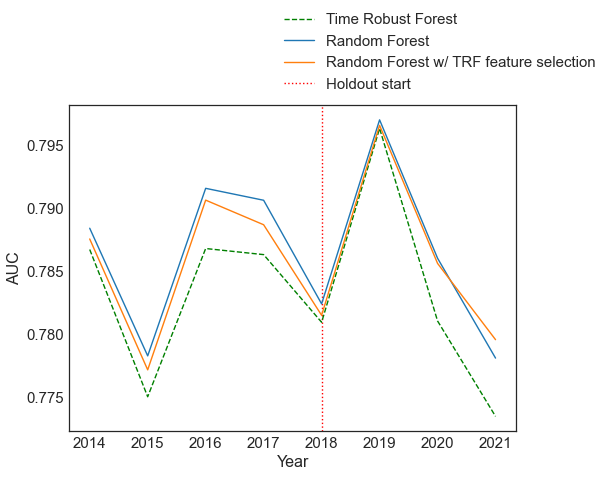

In [63]:
fig, ax = plt.subplots(figsize=(8, 6))
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt"])).plot(label="Random Forest", ax=ax)

pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt_selected_features"])).plot(label="Random Forest w/ TRF feature selection", ax=ax)


ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(training_end_year + 1, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=15, bbox_to_anchor=(0.45, 1.0))
plt.ylabel("AUC", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.savefig("../images/shelter_test_holdout_auc_years_square_fs.eps", format="eps")
plt.show()

## Domain classifier

In [63]:
train["domain"] = 1
test["domain"] = 1
out_of_time["domain"] = 0

In [64]:
domain_data = pd.concat([train, test, out_of_time])

In [65]:
train_domain, test_domain = train_test_split(domain_data, 
                               test_size=0.2,
                               random_state=42)

In [66]:
clf2 = setup(train_domain[features + ["domain"]], target="domain",
             session_id=124, 
             log_experiment=False, 
             experiment_name="shelter_domain",
             silent=True)

rf = create_model('rf')
tuned_domain_rf = tune_model(rf,
                             optimize="AUC",
                             fold=5,
                             n_iter=50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6684,0.6886,0.7742,0.7067,0.7389,0.2874,0.2897
1,0.6655,0.6853,0.7730,0.7040,0.7369,0.2806,0.2830
2,0.6717,0.6866,0.7953,0.7023,0.7459,0.2871,0.2916
3,0.6732,0.6902,0.7952,0.7039,0.7467,0.2911,0.2954
4,0.6691,0.6900,0.7835,0.7038,0.7415,0.2854,0.2885
Mean,0.6696,0.6881,0.7842,0.7041,0.7420,0.2863,0.2896
SD,0.0027,0.0019,0.0097,0.0014,0.0038,0.0034,0.0041


INFO:logs:create_model_container: 2
INFO:logs:master_model_container: 2
INFO:logs:display_container: 3
INFO:logs:RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=9, max_features=1.0, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0002,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=7, min_weight_fraction_leaf=0.0,
                       n_estimators=160, n_jobs=-1, oob_score=False,
                       random_state=124, verbose=0, warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


In [67]:
domain_model = tuned_domain_rf

In [68]:
domain_model.fit(train_domain[features], train_domain["domain"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=9, max_features=1.0, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0002,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=7, min_weight_fraction_leaf=0.0,
                       n_estimators=160, n_jobs=-1, oob_score=False,
                       random_state=124, verbose=0, warm_start=False)

In [69]:
test_domain["pred_domain"] = domain_model.predict_proba(test_domain[features])[:, 1]

In [70]:
roc_auc_score(test_domain["domain"], test_domain["pred_domain"])

0.683725148559403